In [344]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time


In [345]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [8]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)




Weights already downloaded
Load_state output <All keys matched successfully>


In [9]:
import argparse

In [10]:
argparse.BooleanOptionalAction

argparse.BooleanOptionalAction

In [11]:
# model.cuda()

In [12]:
x = torch.randn(1, 3, 64, 64)
x = x.flatten()
x.shape

torch.Size([12288])

### Import dataset and initialize the DataLoader

In [13]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


### For each class, calculate the mean image

In [89]:
num_class = 10
cmeans = [[] for i in range(num_class)]
r = 0
for x,y in loader:
    r+=1
    for c in range(num_class):
        cmeans[c].append(x[y==c])


In [90]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [ ]:
cclist = [c.unsqueeze(0) for c in clist]
centers = torch.cat(cclist)
centers.shape

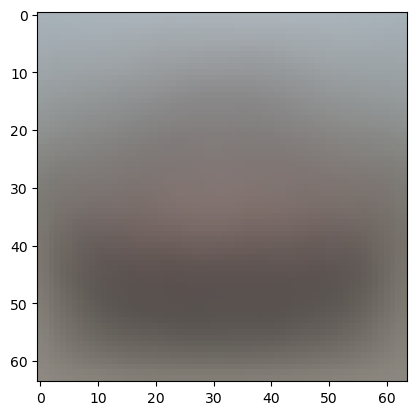

In [91]:
plt.imshow(clist[9].numpy().transpose(1,2,0))

### Define the ClassMaximization class and create an instance of it

In [92]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))


class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, 64, 64))
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [94]:
# create the model
clsmax = ClassMaxim(num_class=10, centers=centers)

In [95]:
clsmax.clone==clsmax.x_c

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [100]:
for param in clsmax.parameters():
    print(type(param.data), param.size())

clsmax.x_c[0].shape

<class 'torch.Tensor'> torch.Size([10, 3, 64, 64])


torch.Size([3, 64, 64])

In [110]:
list(clsmax.parameters())

[Parameter containing:
 tensor([[[[0.5686, 0.5681, 0.5661,  ..., 0.5668, 0.5671, 0.5669],
           [0.5690, 0.5684, 0.5664,  ..., 0.5667, 0.5671, 0.5670],
           [0.5688, 0.5682, 0.5661,  ..., 0.5657, 0.5663, 0.5662],
           ...,
           [0.5153, 0.5144, 0.5117,  ..., 0.5086, 0.5098, 0.5100],
           [0.5159, 0.5151, 0.5126,  ..., 0.5089, 0.5097, 0.5098],
           [0.5159, 0.5151, 0.5127,  ..., 0.5086, 0.5093, 0.5092]],
 
          [[0.6323, 0.6318, 0.6297,  ..., 0.6301, 0.6300, 0.6296],
           [0.6327, 0.6321, 0.6301,  ..., 0.6301, 0.6301, 0.6298],
           [0.6327, 0.6320, 0.6297,  ..., 0.6293, 0.6294, 0.6292],
           ...,
           [0.5399, 0.5390, 0.5360,  ..., 0.5337, 0.5348, 0.5349],
           [0.5400, 0.5391, 0.5365,  ..., 0.5333, 0.5341, 0.5341],
           [0.5396, 0.5388, 0.5363,  ..., 0.5326, 0.5333, 0.5333]],
 
          [[0.6989, 0.6984, 0.6963,  ..., 0.6955, 0.6953, 0.6948],
           [0.6992, 0.6986, 0.6965,  ..., 0.6956, 0.6955, 0.6951],
 

In [111]:
parser = get_training_parser()
args = parser.parse_args(args=[])

epoch = 100
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=0.003, weight_decay=args.weight_decay)#args.lr
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

In [114]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(40):
    for c in range(1):
        xx = clsmax.x_c[c].flatten()#.cuda()
        preds = model(xx)
        targs = torch.tensor(c)#.cuda()


        (-preds[c]).backward()
        # loss = loss_fn(preds, targs)
        
        # loss = loss / args.accum_steps
        # loss.backward()

        print(preds[c])
        
        opt.step()
        opt.zero_grad()
    
        #total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

scheduler.step()

tensor(1.5574, grad_fn=<SelectBackward0>)
tensor(2.5286, grad_fn=<SelectBackward0>)
tensor(2.7787, grad_fn=<SelectBackward0>)
tensor(3.0540, grad_fn=<SelectBackward0>)
tensor(3.2471, grad_fn=<SelectBackward0>)
tensor(3.3144, grad_fn=<SelectBackward0>)
tensor(3.2991, grad_fn=<SelectBackward0>)
tensor(3.5806, grad_fn=<SelectBackward0>)
tensor(3.7763, grad_fn=<SelectBackward0>)
tensor(3.9521, grad_fn=<SelectBackward0>)
tensor(4.0764, grad_fn=<SelectBackward0>)
tensor(4.1131, grad_fn=<SelectBackward0>)
tensor(4.3527, grad_fn=<SelectBackward0>)
tensor(4.3751, grad_fn=<SelectBackward0>)
tensor(4.6343, grad_fn=<SelectBackward0>)
tensor(4.7068, grad_fn=<SelectBackward0>)
tensor(4.8893, grad_fn=<SelectBackward0>)
tensor(5.0124, grad_fn=<SelectBackward0>)
tensor(5.1493, grad_fn=<SelectBackward0>)
tensor(5.2786, grad_fn=<SelectBackward0>)
tensor(5.3794, grad_fn=<SelectBackward0>)
tensor(5.4742, grad_fn=<SelectBackward0>)
tensor(5.6504, grad_fn=<SelectBackward0>)
tensor(5.6988, grad_fn=<SelectBack

In [116]:
torch.norm(clsmax.x_c[0])

tensor(62.5754, grad_fn=<LinalgVectorNormBackward0>)

In [117]:
torch.norm(centers[0])

tensor(62.3464)

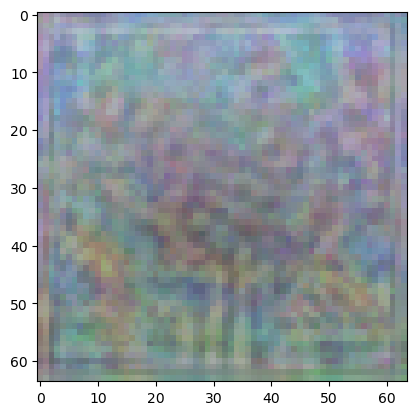

In [118]:
plt.imshow(clsmax.x_c[0].detach().numpy().transpose(1,2,0))

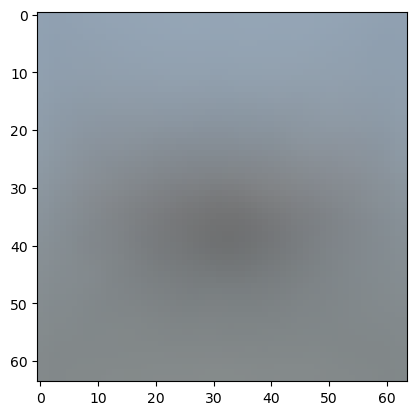

In [119]:
plt.imshow(clsmax.clone[0].detach().numpy().transpose(1,2,0))

In [121]:
clsmax.clone[0]==clsmax.x_c[0]

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False,  True, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [

# Same thing for CNNs

In [397]:
# USE CNN that is pretrained on cifar10
from cifar10_models.resnet import *

model = resnet18()
weights = torch.load('state_dicts/resnet18.pt')
model.load_state_dict(weights)

<All keys matched successfully>

In [398]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    # transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


In [399]:
num_class = 10
cmeans = [[] for i in range(num_class)]
r = 0
for x,y in loader:
    r+=1
    for c in range(num_class):
        cmeans[c].append(x[y==c])

In [400]:
len(cmeans[c][3])

97

In [401]:
torch.cat(cmeans[0]).shape

torch.Size([5000, 3, 32, 32])

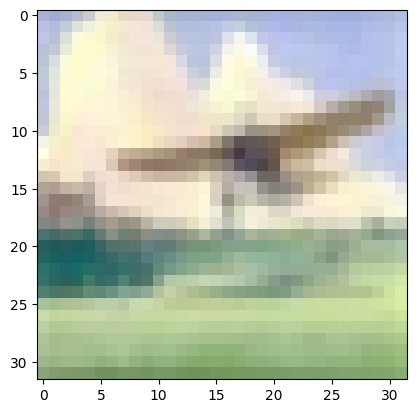

In [402]:
plt.imshow((torch.cat(cmeans[0])[123]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))

In [403]:
torch.cat(cmeans[0]).mean(dim=0).shape

torch.Size([3, 32, 32])

In [404]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [405]:
cclist = [c.unsqueeze(0) for c in clist]
centers = torch.cat(cclist)
centers.shape

torch.Size([10, 3, 32, 32])

In [406]:
centers

tensor([[[[ 3.1257e-01,  2.9659e-01,  3.0632e-01,  ...,  3.1016e-01,
            3.0275e-01,  3.0560e-01],
          [ 3.1089e-01,  2.9386e-01,  3.0242e-01,  ...,  2.9926e-01,
            2.9296e-01,  2.9936e-01],
          [ 3.0559e-01,  2.8566e-01,  2.9294e-01,  ...,  2.8804e-01,
            2.8376e-01,  2.9428e-01],
          ...,
          [ 9.3153e-02,  6.9687e-02,  7.3089e-02,  ...,  5.6257e-02,
            5.7070e-02,  7.1982e-02],
          [ 9.3518e-02,  7.0541e-02,  7.8216e-02,  ...,  6.2682e-02,
            6.2986e-02,  7.3677e-02],
          [ 9.8999e-02,  7.9466e-02,  9.0233e-02,  ...,  7.1360e-02,
            6.6033e-02,  7.2226e-02]],

         [[ 6.1643e-01,  5.9989e-01,  6.0990e-01,  ...,  6.1356e-01,
            6.0559e-01,  6.0542e-01],
          [ 6.1597e-01,  5.9648e-01,  6.0453e-01,  ...,  6.0465e-01,
            5.9807e-01,  6.0048e-01],
          [ 6.0948e-01,  5.8600e-01,  5.9128e-01,  ...,  5.9047e-01,
            5.8621e-01,  5.9379e-01],
          ...,
     

### Define the ClassMaximization class and create an instance of it

In [430]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))

class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None, reso=32):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, reso, reso))
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [431]:
centers.shape

torch.Size([10, 3, 32, 32])

In [432]:
# create the model
# clsmax = ClassMaxim(num_class=10, centers=centers, reso=32)
clsmax = ClassMaxim(num_class=10, reso=32)

In [433]:
torch.sum(clsmax.clone!=clsmax.x_c)

tensor(0)

In [434]:
parser = get_training_parser()
args = parser.parse_args(args=[])

epoch = 100
lr = 0.01
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=lr, weight_decay=args.weight_decay)#args.lr
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

lamb = 0.05

In [422]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(1000):
    # for c in range(1):
    c=1
    xx = clsmax.x_c[c]#.flatten()#.cuda()
    #print(xx.size())
    preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
    preds = preds.squeeze(0)

    print(preds.size())
    targs = torch.tensor(c)#.cuda()

    loss = (preds[c] - lamb*(torch.norm(clsmax.x_c[c])))
    (loss).backward()
    # loss = loss_fn(preds, targs)
    
    # loss = loss / args.accum_steps
    # loss.backward()

    print(preds)
    
    grad = clsmax.x_c.grad / (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
    clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent
    # opt.step()
    # opt.zero_grad()

    #total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

# scheduler.step()

torch.Size([10])
tensor([-0.8057, -0.9174,  1.3647,  0.0253, -0.3659, -0.6623,  4.1707, -0.9259,
        -0.9544, -0.9289], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.8053, -0.9159,  1.3517,  0.0235, -0.3662, -0.6617,  4.1789, -0.9247,
        -0.9529, -0.9274], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.8050, -0.9143,  1.3387,  0.0216, -0.3665, -0.6610,  4.1872, -0.9234,
        -0.9514, -0.9258], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.8047, -0.9128,  1.3257,  0.0197, -0.3668, -0.6604,  4.1955, -0.9222,
        -0.9498, -0.9242], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.8043, -0.9112,  1.3126,  0.0178, -0.3671, -0.6597,  4.2038, -0.9209,
        -0.9483, -0.9227], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.8040, -0.9096,  1.2994,  0.0159, -0.3674, -0.6591,  4.2122, -0.9197,
        -0.9467, -0.9211], grad_fn=<SqueezeBackward1>)
torch.Size([10])
tensor([-0.8036, -0.9079,  1.2861,  0.0140, -0.3677, -0.6584,  4.2206, 

KeyboardInterrupt: 

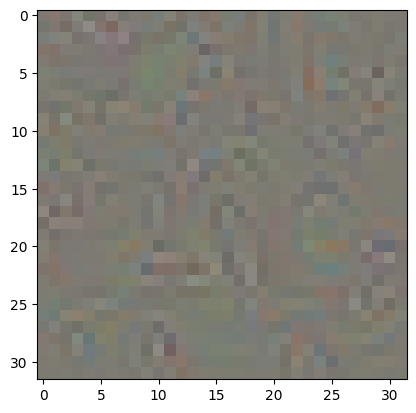

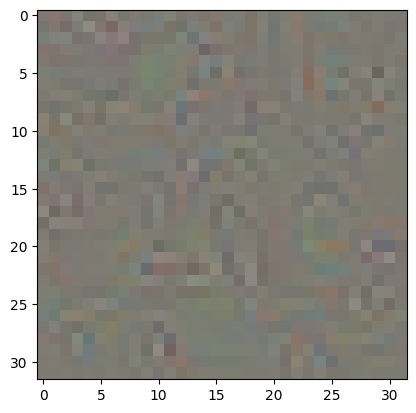

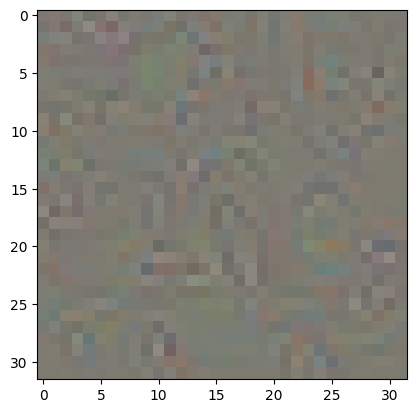

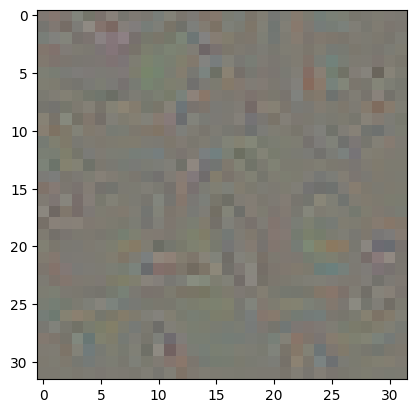

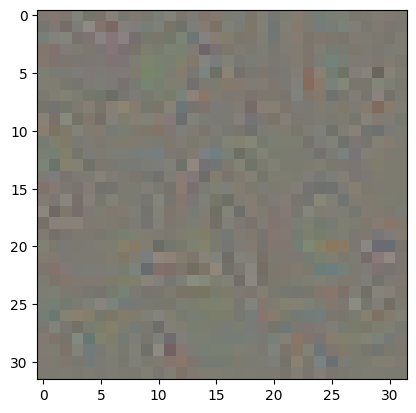

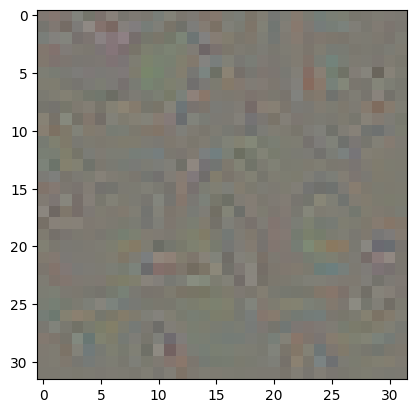

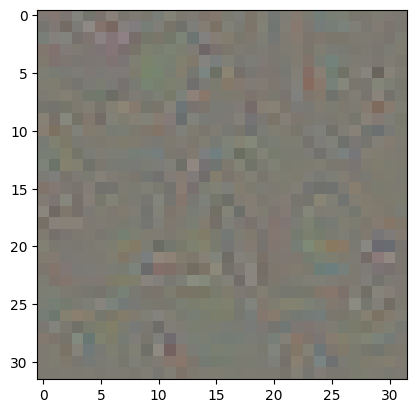

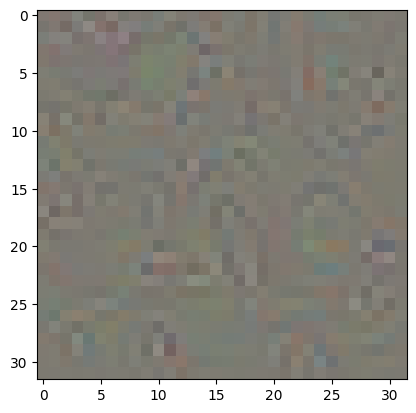

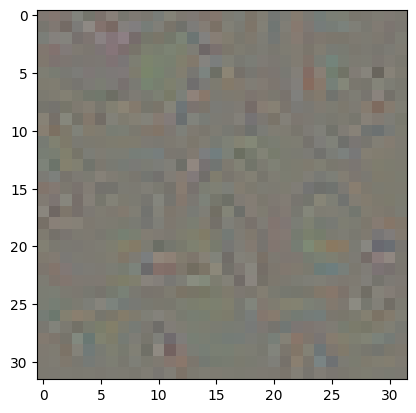

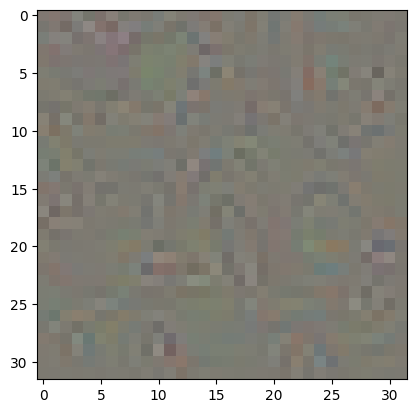

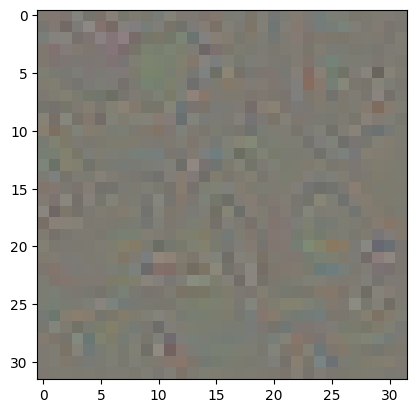

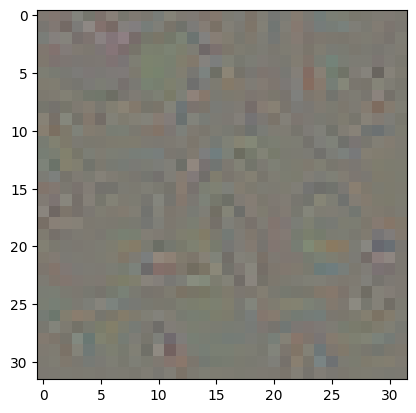

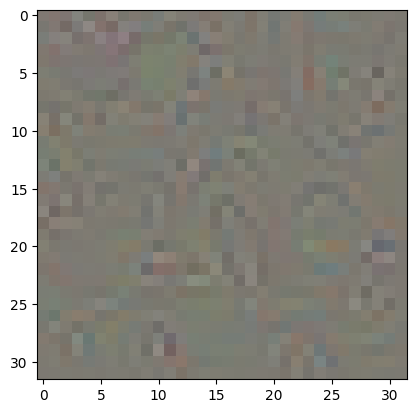

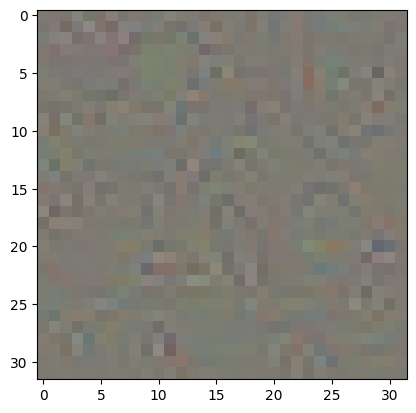

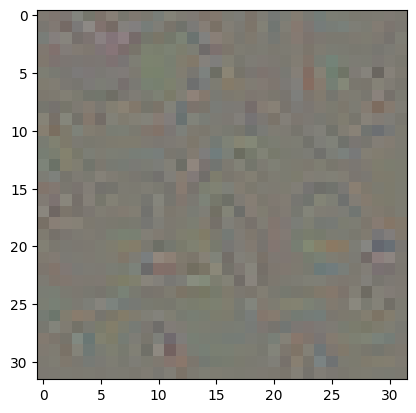

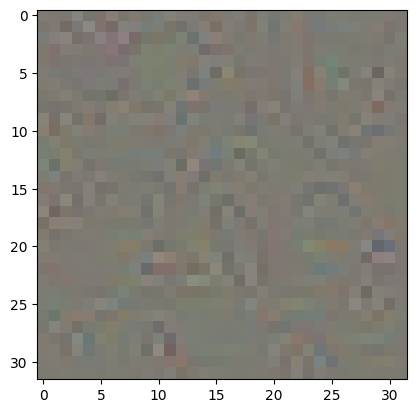

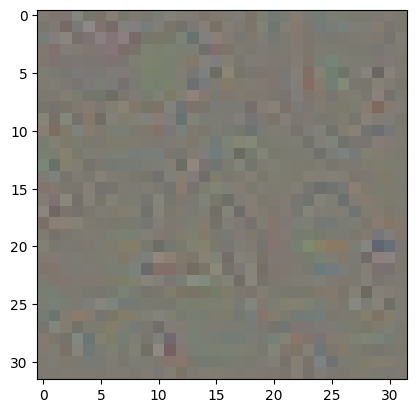

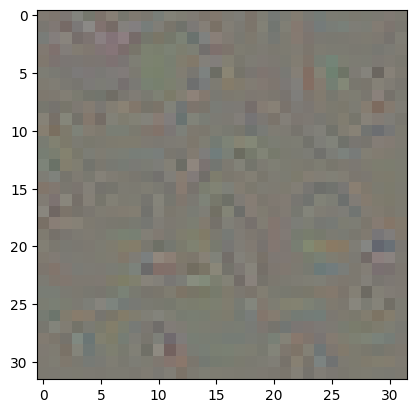

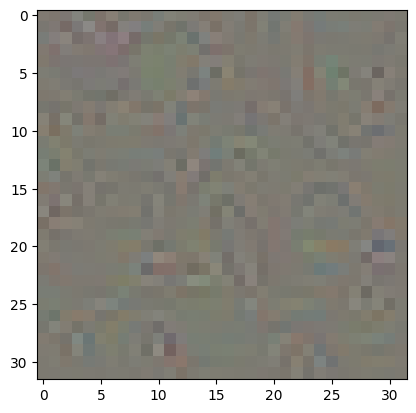

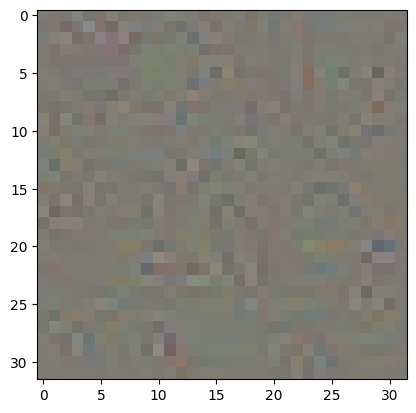

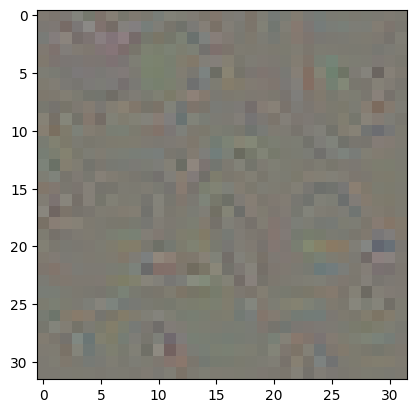

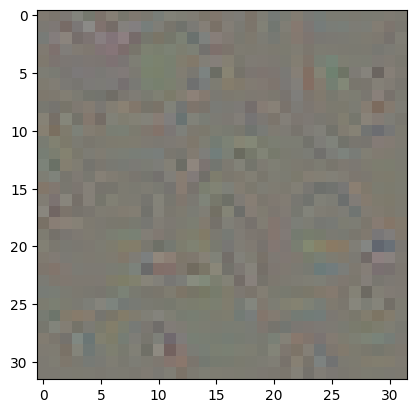

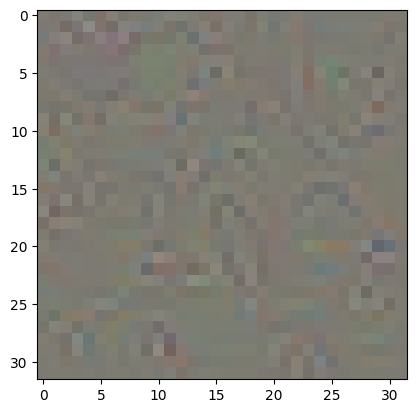

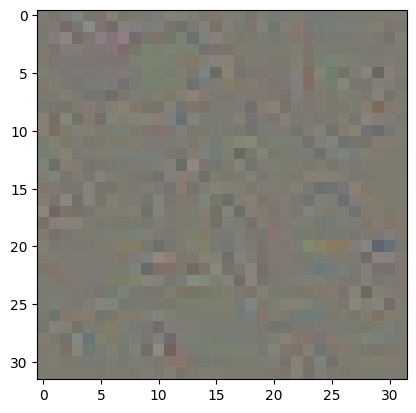

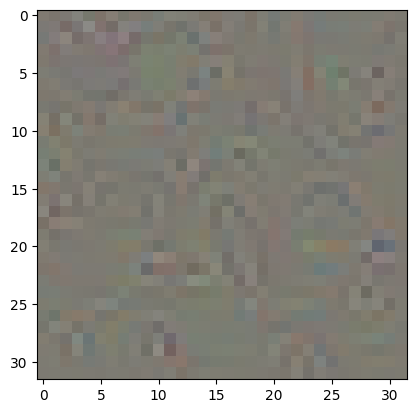

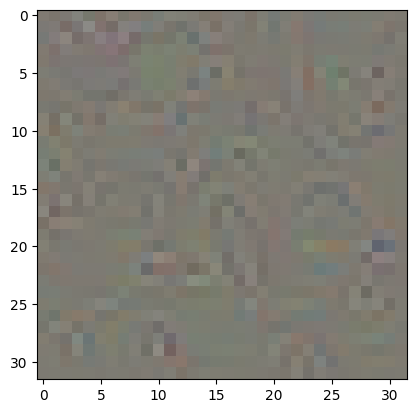

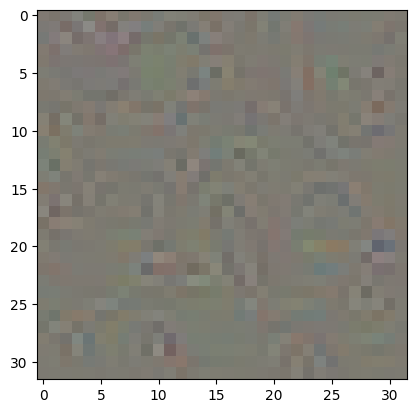

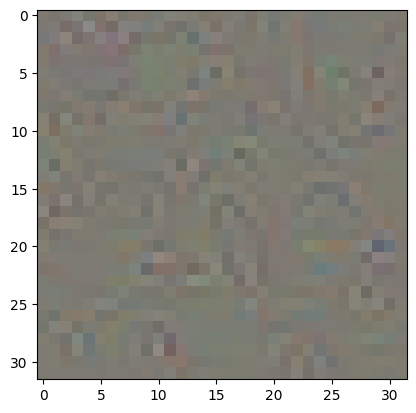

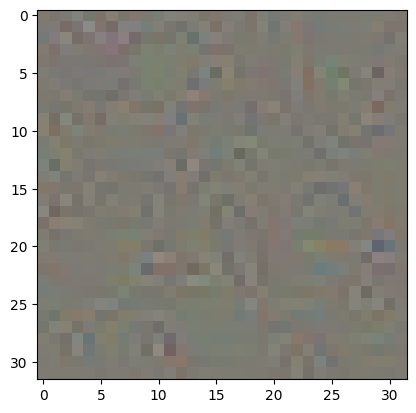

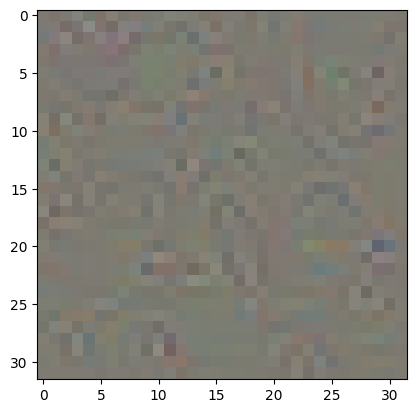

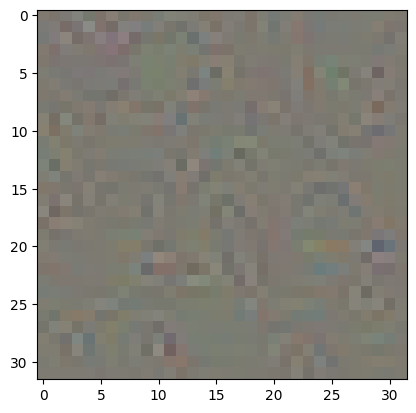

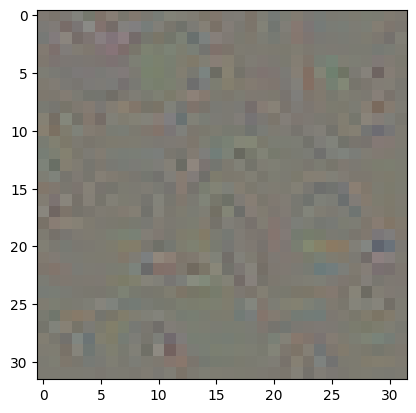

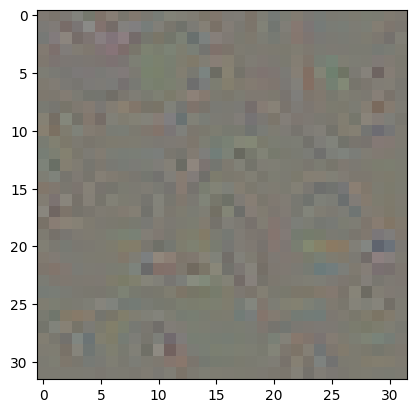

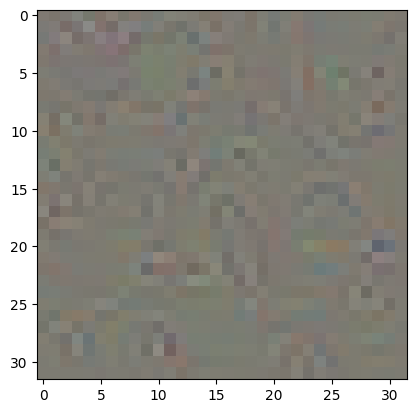

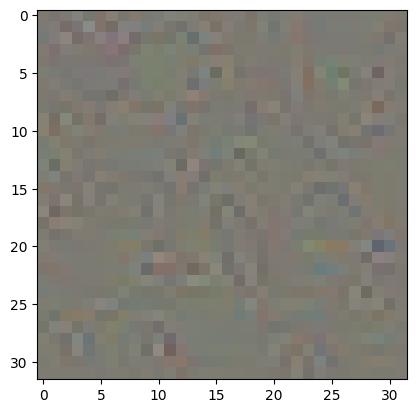

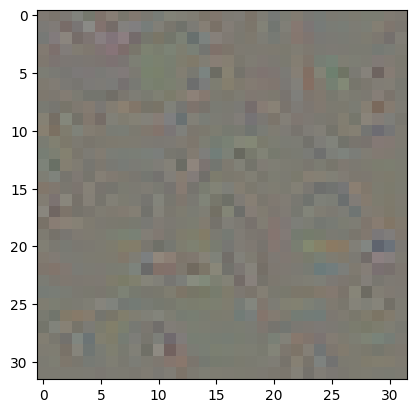

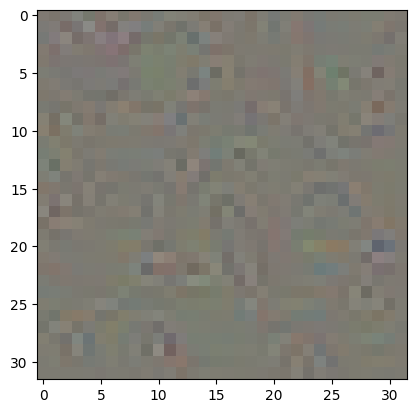

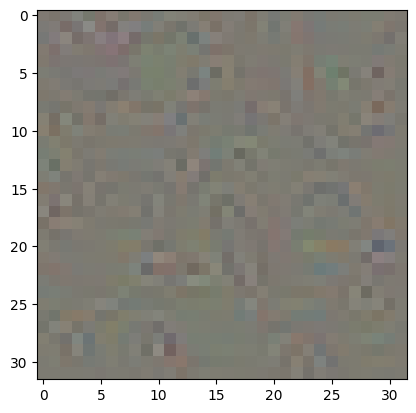

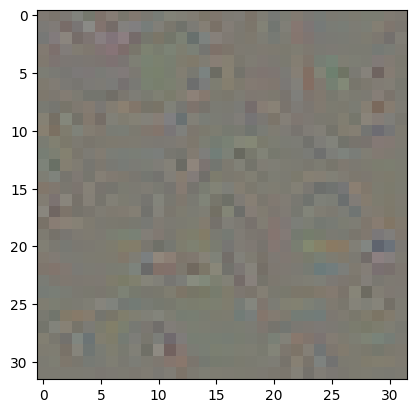

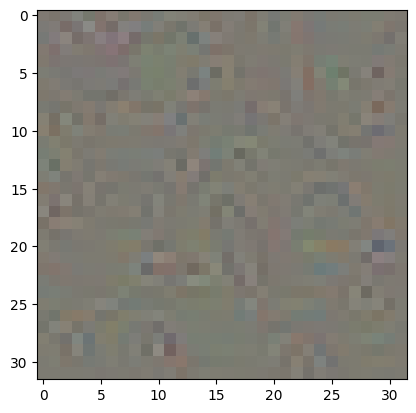

In [436]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)


start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

plt.figure()
for i in range(40):
    plt.imshow((clsmax.x_c[c]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()
    for step in range(250):
        # for c in range(1):
        c=1
        xx = clsmax.x_c[c]#.flatten()#.cuda()
        #print(xx.size())
        preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
        preds = preds.squeeze(0)

        # print(preds.size())
        targs = torch.tensor(c)#.cuda()

        loss = (preds[c] - lamb*(torch.norm(clsmax.x_c[c])))
        (loss).backward()
        # loss = loss_fn(preds, targs)
        
        # loss = loss / args.accum_steps
        # loss.backward()

        # print(preds)
        
        grad = clsmax.x_c.grad / (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
        clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent
        # opt.step()
        # opt.zero_grad()

        #total_loss.update(loss.item() * args.accum_steps, 1)

    end = time.time()

    # scheduler.step()

In [362]:
grad = clsmax.x_c.grad / (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
grad.shape

AttributeError: 'NoneType' object has no attribute 'layout'

In [363]:
        
clsmax.x_c = clsmax.x_c + grad*lr # update step, gradient ascent

TypeError: cannot assign 'torch.FloatTensor' as parameter 'x_c' (torch.nn.Parameter or None expected)

In [364]:
preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
preds = preds.squeeze(0)

print(preds.size())
targs = torch.tensor(c)#.cuda()

loss = -preds[c] + lamb*(torch.norm(clsmax.x_c[c]))
(loss).backward()

torch.Size([10])


In [365]:
clsmax.x_c.shape

torch.Size([10, 3, 32, 32])

In [366]:
torch.norm(clsmax.x_c.grad)

tensor(0.1000)

In [367]:
torch.norm(clsmax.x_c.grad[0])

tensor(0.)

In [368]:
clsmax.x_c.grad

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
     

In [369]:
clsmax.x_c.grad[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [370]:
clsmax.x_c.grad[c]/(torch.norm(clsmax.x_c.grad[c]) + 1e-5)

tensor([[[-3.7081e-02,  4.7461e-03,  1.2668e-02,  ...,  6.0139e-03,
          -2.0664e-03,  5.7649e-04],
         [ 1.7625e-02, -1.2296e-02,  1.1483e-02,  ..., -1.3780e-03,
          -5.6481e-03,  4.1995e-03],
         [ 2.0926e-02, -5.6596e-03,  6.2855e-02,  ...,  8.6839e-03,
          -7.5836e-03,  2.9203e-03],
         ...,
         [ 6.2647e-03,  4.9728e-03,  1.1114e-02,  ..., -2.8924e-03,
           4.1232e-04, -7.3965e-04],
         [ 4.6777e-03,  5.4249e-03,  1.1560e-02,  ...,  2.7607e-03,
           2.2255e-03,  3.4972e-04],
         [-1.0808e-03,  1.1279e-03, -2.5531e-03,  ...,  2.7925e-03,
           2.1548e-03,  5.4346e-04]],

        [[-5.0760e-03,  3.0611e-02, -3.4280e-03,  ...,  2.0261e-03,
          -2.8034e-03,  2.0898e-03],
         [ 3.3846e-02, -1.6572e-02, -7.6664e-02,  ...,  2.9502e-06,
          -2.4238e-03,  2.5404e-03],
         [-1.8722e-03, -4.4180e-02, -6.3806e-03,  ...,  1.7200e-02,
           4.2132e-03, -1.6563e-03],
         ...,
         [ 2.2226e-03,  1

In [371]:
clsmax.x_c[0].grad

/var/folders/dp/4fr32ggj4tb41_86_5pj1l8h0000gn/T/ipykernel_90916/1679040594.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  clsmax.x_c[0].grad


In [372]:
torch.norm(clsmax.x_c[0])

tensor(23.9390, grad_fn=<LinalgVectorNormBackward0>)

In [391]:
preds.shape

torch.Size([10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


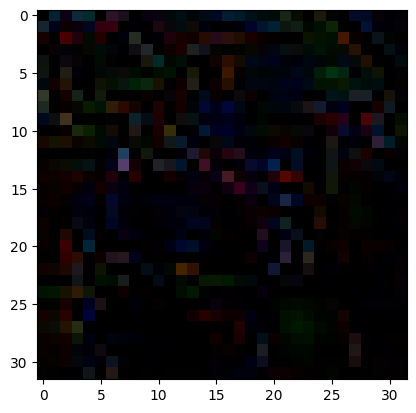

In [392]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)
plt.imshow((clsmax.x_c[c]).detach().numpy().transpose(1,2,0))

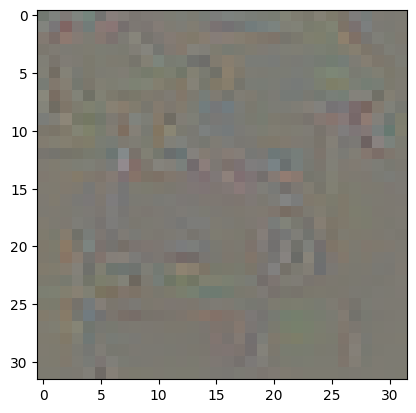

In [378]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)
plt.imshow((clsmax.x_c[c]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))

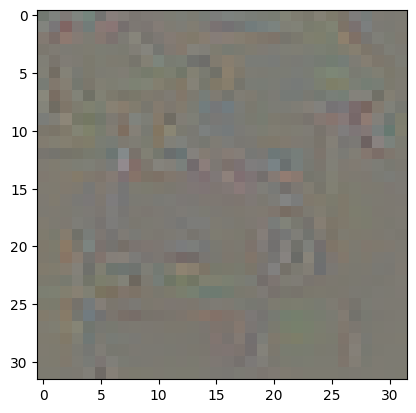

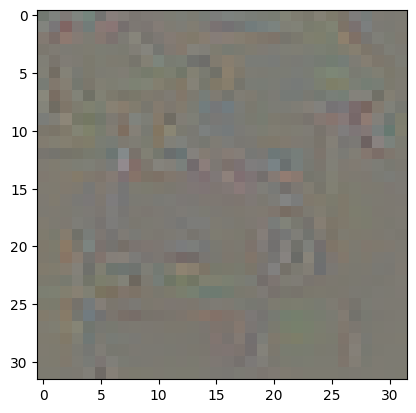

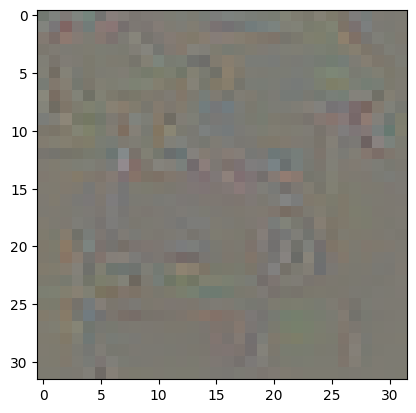

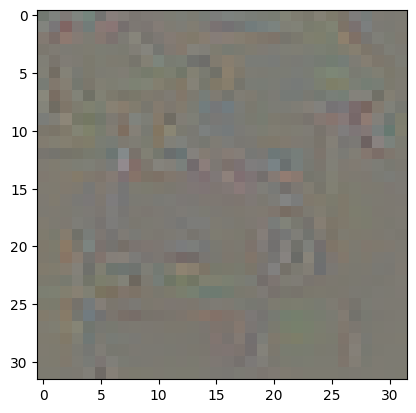

In [375]:
plt.figure()
for i in range(4):
    plt.imshow((clsmax.x_c[c]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()

In [376]:
std_tens

tensor([[[0.2471]],

        [[0.2435]],

        [[0.2616]]])

In [377]:
mean_tens

tensor([[[0.4914]],

        [[0.4822]],

        [[0.4465]]])

In [387]:
out = model((clsmax.x_c[1]).unsqueeze(0))
cls_lbl = out.argmax() # model((clsmax.x_c[0]*std_tens + mean_tens).unsqueeze(0)).argmax()
# cls_lbl = model((centers[0]).unsqueeze(0)).argmax()

In [388]:
out

tensor([[-0.6973,  7.4458, -1.0537, -0.9642, -1.0997, -1.0196, -0.9951, -1.1148,
         -0.6196,  0.1183]], grad_fn=<AddmmBackward0>)

In [389]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [390]:
print(cifar10_classes[cls_lbl])

automobile
